## N-gram MLP

2024.07.30

Title : A Neural Probabilistic Language Model by Yoshua Bengio et al.

Idea : input a sentence with N-1 character, using look-up table to map a embedding, aggregrate into a intermediate neuron, then using MLP to map into vocab logits and softmax. Basically there are 3 MLPs: 1. embedding 2.hidden dim 3. output

embedding layer (look-up table)算一种没有非线形层的神经网络

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# read all the words
words = open("makemore/names.txt").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [7]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # block size is the context length, how many characters do we take to predict the next tone? block size = N - 1
X,Y = [],[]
for w in words:
    # print(w)
    context = [0] * block_size # padd
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join([itos[i] for i in context]), '----->', ch)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)


In [129]:
X.shape,X.dtype,Y.shape,Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

## Embedding word

In [7]:
C = torch.randn((27,2))

### 使用矩阵乘法从one-hot来得到embedding向量
$(0,0,1,0,0) \times (C_1, C_2, C_3, C_4, C_5)^T=\sum\limits_{i=1}^{5} one\_hot _i \times C_i^T$

In [15]:
X[5,2]

tensor(0)

In [16]:
C[0]

tensor([-0.9071,  0.0226])

In [24]:
x_one_hot = F.one_hot(X,num_classes=27).float() # [B,3,27]
emb = x_one_hot @ C
emb.shape, emb.dtype

(torch.Size([32, 3, 2]), torch.float32)

In [20]:
# test more one_hot
F.one_hot(torch.tensor([5]),num_classes=27)

tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0]])

In [18]:
output_one_hot[5,2]

tensor([-0.9071,  0.0226])

### Pytorch索引高级 - 用一个tensor去索引另一个tensor
使用索引来得到embedding向量

In [6]:
C = torch.randn((27,2)) # look-up table

In [8]:
C[5]

tensor([0.3232, 0.2405])

In [10]:
C[X].shape
# tensor index another tensor
# X is the index tensor is a integer tensor with shape [32,3]; Xij in [0,m-1]
# C is the output tensor with any shape [m,n]
# C[X] is [32,3,n] tensor with the same shape as X, but with n as the last dimension

torch.Size([32, 3, 2])

In [17]:
# index T: [x,y] , 0 <= Cij < m --- int
# source C: [m,n1,n2,n3]  
# C[T] -> [x,y,n1,n2,n3] tensor 使用T的每一个interger value作为索引来索引C的第一个维度
# source和index的维度没有任何要求，唯一要求index的每一个value必须在0到m-1之间，m为C的第一个维度大小
# 将index的每一个值换为source的第一个维度对应的sub-tensor. output[i,j] = source[index[i,j],...] i,j \in x,y 
m = 10 
n1 = 5
n2 = 15
n3 = 25
x = 2
y = 3
table = torch.randint(0,m,(x,y))
C = torch.randn((m,n1,n2,n3))

In [19]:
C[table].shape

torch.Size([2, 3, 5, 15, 25])

In [25]:
# 复习NLLLoss 索引 , 用两个tensor去索引一个tensor
batch = 3
n_classes = 5
predict = F.softmax(torch.randn(batch,n_classes),dim=-1)
label = torch.randint(0,n_classes,(batch,))

prob = predict[torch.arange(batch),label]
loss = -prob.log().mean() # NLLLoss

In [23]:
predict

tensor([[0.2402, 0.1531, 0.1271, 0.2328, 0.2468],
        [0.0878, 0.2912, 0.0593, 0.1152, 0.4465],
        [0.2574, 0.3128, 0.0826, 0.0927, 0.2545]])

In [24]:
label

tensor([4, 4, 2])

In [22]:
prob

tensor([0.2468, 0.4465, 0.0826])

In [12]:
x1 = 3
x2 = 4
x3 = 5
x4 = 6

a = 10
b = 20
c = 30
d =2 
index = torch.randint(0,a,(x1,x2,x3,x4))
source = torch.randn((a,d))

In [16]:
index[0,0,0,0]

tensor(8)

In [13]:
source[index].shape

torch.Size([3, 4, 5, 6, 2])

In [15]:
source

tensor([[ 0.6583, -0.4123],
        [ 0.0683, -0.3913],
        [-1.7352, -0.5125],
        [ 0.6878, -0.3927],
        [-0.4140,  1.4977],
        [-0.4280, -0.5760],
        [-1.2185,  0.8800],
        [-0.8689,  1.4493],
        [ 0.3409,  1.7758],
        [ 0.2171, -0.0460]])

In [14]:
source[index][0,0,0,0]

tensor([0.3409, 1.7758])

## Hidden layer

In [23]:
H1 = torch.randn((6, 100)) # 6代表着前三个token embedding的concatenation, 100代表该层神经元的维度
b1 = torch.randn(100)

In [30]:
# concatenate the embeddings of the first three tokens
emb = emb.reshape(-1, 3*2) # [B,3,2] -> [B,6]
emb = emb.reshape(-1, 3,2) # [B,3,2] -> [B,6]

In [ ]:
# method1 - concatenate
# 代码并不robust,当改变block size时这段代码也需要改变
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]],dim=1)

In [34]:
torch.cat(torch.unbind(emb,dim=1),1).shape

torch.Size([32, 6])

In [39]:
h = torch.tanh(emb.reshape(-1,6) @ H1 + b1)

In [41]:
h.shape

torch.Size([32, 100])

## Output layer

In [44]:
H2 = torch.randn((100, 27)) # 6代表着前三个token embedding的concatenation, 100代表该层神经元的维度
b2 = torch.randn(27)

In [45]:
logits = h @ H2 + b2

In [47]:
logits.shape

torch.Size([32, 27])

In [48]:
counts = logits.exp()

In [49]:
prob = counts / counts.sum(dim=1, keepdim=True)

In [51]:
prob.shape

torch.Size([32, 27])

In [55]:
# 训练时具有真正的标签Y
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [56]:
# 提取真正标签的概率作为likelihood
prob[torch.arange(Y.shape[0]),Y]

tensor([8.5424e-08, 7.2093e-06, 4.2882e-12, 7.1539e-04, 1.4455e-16, 3.7382e-17,
        4.1219e-06, 2.0669e-02, 3.3787e-06, 3.7858e-13, 5.9700e-10, 3.0050e-12,
        2.4489e-06, 4.4295e-03, 2.6744e-07, 7.0941e-19, 2.0409e-07, 1.6180e-06,
        1.9667e-08, 6.9298e-05, 1.6719e-07, 8.1483e-10, 1.3826e-05, 2.7351e-07,
        7.0711e-14, 1.9710e-07, 2.5540e-06, 5.5626e-09, 4.2181e-08, 2.8268e-08,
        3.7900e-07, 9.4658e-12])

In [57]:
# Loss = average NLLLoss
loss = -prob[torch.arange(Y.shape[0]),Y].log().mean()
loss

tensor(18.3554)

## Combine Emb, Hidden, Output layer 

more respectable code

In [59]:
X.shape, Y.shape # dataset

(torch.Size([32, 3]), torch.Size([32]))

In [111]:
g = torch.Generator().manual_seed(2147483467)
c = torch.randn((27,2),generator=g)
W1 = torch.randn((6, 100),generator=g)
b1 = torch.randn(100,generator=g)
W2 = torch.randn((100, 27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [c, W1, b1, W2, b2]

In [64]:
sum(p.nelement() for p in params)

3481

In [69]:
# NLLLoss，本质的损失函数
emb = c[X]
h = torch.tanh(emb.reshape(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp() # pseudo counts like bigram
prob = counts / counts.sum(dim=1, keepdim=True)
loss = -prob[torch.arange(Y.shape[0]),Y].log().mean()
loss

tensor(16.8003)

In [72]:
# equavalent to NLLLoss in pytorch
F.nll_loss(prob.log(), Y)

tensor(16.8003)

In [70]:
# CrossEntropyLoss
emb = c[X]
h = torch.tanh(emb.reshape(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y)
loss

tensor(16.8003)

In [71]:
F.cross_entropy(logits, Y)
# why cross entropy
# 1. pytorch don't create all the intermediate tensors like, 使用fused kernel来整体计算----cluster up into one operation
# 2. backward propogation更有效, analytically and mathematically it's often a very much simpler backward pass. 联想micrograd的tanh求导是集成的，不需要借助其他函数如exp, sum, divid等操作, 也就是tanh的导数是有解析求解的，不用借助其他函数的求导

# 总结：有一套集成的fused kernel , 且在算梯度的时候可以利用解析解，不用转化为一些标准的操作如exp, sum, divid等

tensor(16.8003)

In [76]:
# why we should use cross entropy in practical reason
# work
logits = torch.tensor([[-10,-3,0,10]])
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)
prob

tensor([[2.0611e-09, 2.2602e-06, 4.5398e-05, 9.9995e-01]])

In [81]:
# didnot work for really large positive number
logits = torch.tensor([[-10,-3,0,1000]])
counts = logits.exp() # this creats inf for exp(100)
prob = counts / counts.sum(dim=1, keepdim=True)
prob

tensor([[0., 0., 0., nan]])

In [100]:
# how pytorch kernel solve this ?
# 总是可以对logits加上或者减去一个值(offset)，并不改变最后的输出
logits = torch.tensor([[-5,-3,0,5]]) - 5
counts = logits.exp() # this creats inf for exp(100)
prob = counts / counts.sum(dim=1, keepdim=True)
prob

# pytorch exp 对于很小的负数是允许的，但是对于很大的正数会overflow,因此pytorch计算最大的数字，并减去

tensor([[4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01]])

In [101]:
logits = torch.tensor([[-100,-3,0,100]]) - 100
counts = logits.exp() # this creats inf for exp(100)
prob = counts / counts.sum(dim=1, keepdim=True)
prob

tensor([[0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00]])

总结：为什么使用cross entropy or pytorch自带的函数
1. 由于具有kernel且封装到了一个运算中，forward pass和backward pass更加高效
2. 通过一些trick保证了计算的数值稳定性

为什么比NLLLoss好
1. NLLLoss还需要计算log概率，虽然可以使用log-likihood保证概率计算的数值稳定性，但是毕竟是不同的kernel，因此肯定会慢一点

### Implementation the forward pass and overfitting in one batch

- computation loss  

- zero grad  

- compute grad

- gradient descent

In [130]:
X.shape,Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [14]:
# split dataset
# Training : 用来训练网络参数，通过梯度下降的方法
# Validation : 用来调整超参数，通过贪心算法
# Test : 在最终评价模型的性能，只能最少次数的用到，不然还是会overfitting
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# build the dataset
def build_dataset(words):
    block_size = 3 # block size is the context length, how many characters do we take to predict the next tone? block size = N - 1
    X,Y = [],[]
    for w in words:
        # print(w)
        context = [0] * block_size # pad
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join([itos[i] for i in context]), '----->', ch)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y


Xtr, Ytr = build_dataset(words=words[:n1])
Xva, Yva = build_dataset(words=words[n1:n2])
Xte, Yte = build_dataset(words=words[n2:])

In [15]:
print(len(words[:n1]),Xtr.shape, Ytr.shape)
print(len(words[n1:n2]),Xva.shape, Yva.shape)
print(len(words[n2:]),Xte.shape, Yte.shape)

25626 torch.Size([182437, 3]) torch.Size([182437])
3203 torch.Size([22781, 3]) torch.Size([22781])
3204 torch.Size([22928, 3]) torch.Size([22928])


注意：较大的梯度可以保证训练的梯度是正确的，噪音比较少；但有时候噪音比较多反而对训练有帮助？

什么是欠拟合？当training和validation差不多的时候欠拟合
什么时候开始过拟合，training loss开始比validation loss低的时候

In [35]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
stepi_list = []
lossi_list = []
for batch_size in batch_sizes:
    g = torch.Generator().manual_seed(2147483467)
    C = torch.randn((27,10),generator=g)
    W1 = torch.randn((30, 200),generator=g)
    b1 = torch.randn(200,generator=g)
    W2 = torch.randn((200, 27),generator=g)
    b2 = torch.randn(27,generator=g)
    parameters = [C, W1, b1, W2, b2]
    stepi = []
    lossi = []
    for p in parameters:
        p.requires_grad = True

    for _ in range(100000):
        # minibtach construct
        ix = torch.randint(0, len(Xtr), (batch_size,))
        # forward pass
        emb = C[Xtr[ix]] # [32,3,2]
        h = torch.tanh(emb.reshape(-1,30) @ W1 + b1)
        logits = h @ W2 + b2 # [32, 27]
        loss = F.cross_entropy(logits, Ytr[ix])
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
        # update 
        lr = 0.1
        for p in parameters:
            p.data += -lr * p.grad
        stepi.append(_)
        lossi.append(loss.item())
    stepi_list.append(stepi)
    lossi_list.append(lossi)
    # print(loss.item())

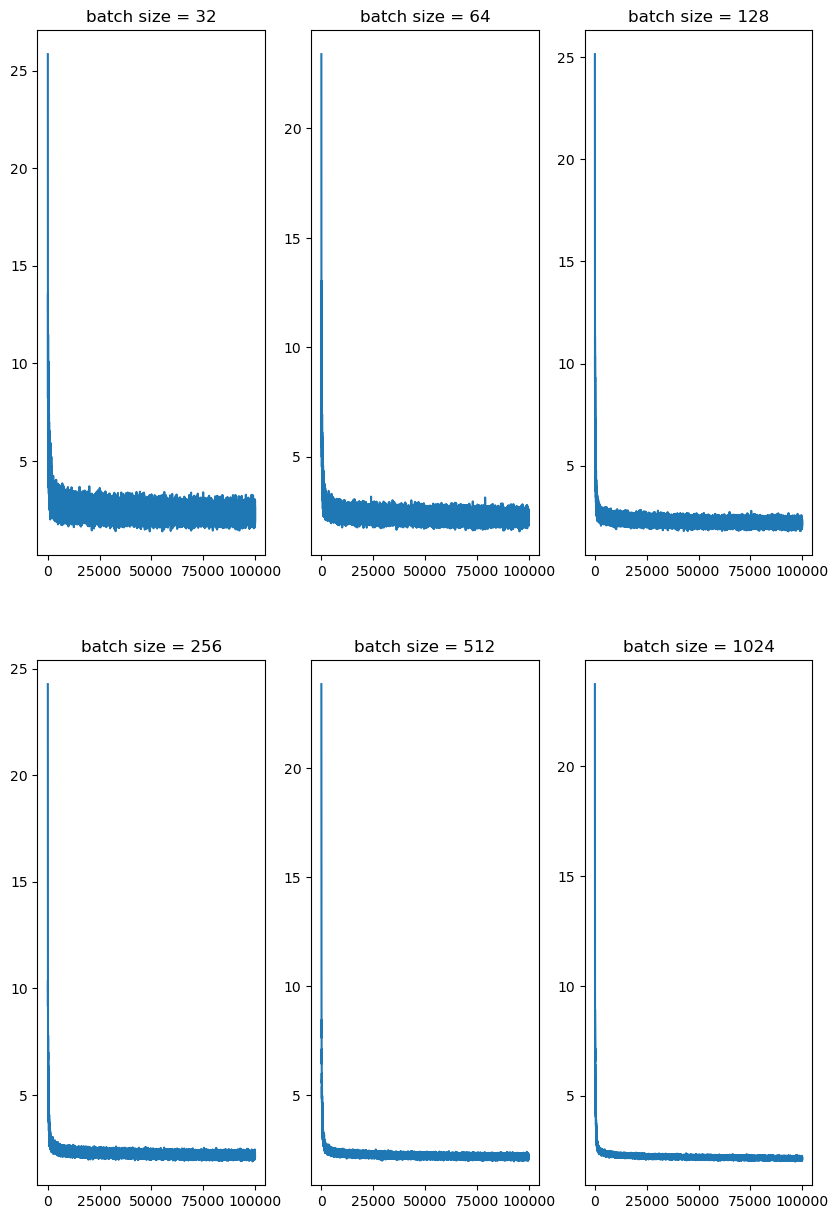

In [36]:
# 打印不同batch size的loss曲线,画成不同的子图
fig, axs = plt.subplots(2, 3, figsize=(10, 15))
for i, ax in enumerate(axs.flat):
    ax.plot(stepi_list[i], lossi_list[i])
    ax.set_title(f'batch size = {batch_sizes[i]}')

In [44]:
batch_size = 128
g = torch.Generator().manual_seed(2147483467)
C = torch.randn((27,10),generator=g)
W1 = torch.randn((30, 200),generator=g)
b1 = torch.randn(200,generator=g)
W2 = torch.randn((200, 27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C, W1, b1, W2, b2]
stepi = []
lossi = []
for p in parameters:
    p.requires_grad = True
# weight decay
for _ in range(100000):
    # minibtach construct
    ix = torch.randint(0, len(Xtr), (batch_size,))
    # forward pass
    emb = C[Xtr[ix]] # [32,3,2]
    h = torch.tanh(emb.reshape(-1,30) @ W1 + b1)
    logits = h @ W2 + b2 # [32, 27]
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update 
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
    stepi.append(_)
    lossi.append(loss.item())

超过andrej的几个特点。更大的benchsize(不能太大，太大了收敛有问题，因此正确的梯度不一定是好的，包含一定噪音的梯度是好的)，训练一段时间weight decay

In [50]:
for _ in range(100000):
    # minibtach construct
    ix = torch.randint(0, len(Xtr), (batch_size,))
    # forward pass
    emb = C[Xtr[ix]] # [32,3,2]
    h = torch.tanh(emb.reshape(-1,30) @ W1 + b1)
    logits = h @ W2 + b2 # [32, 27]
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update 
    lr = 0.0001
    for p in parameters:
        p.data += -lr * p.grad
    stepi.append(_)
    lossi.append(loss.item())

In [52]:
# valid loss
emb = C[Xva] # [32,3,2]
h = torch.tanh(emb.reshape(-1,30) @ W1 + b1)
logits = h @ W2 + b2 # [32, 27]
loss = F.cross_entropy(logits, Yva)
print(loss.item())

2.169905424118042


In [123]:
logits.max(1)

torch.return_types.max(
values=tensor([ 7.2571, 10.7497, 13.3670, 17.2214, 11.7279,  7.2571,  7.2076, 10.4600,
        12.5670, 14.1773, 17.4980, 14.8326,  7.2571,  9.2676, 14.0708, 18.3452,
         7.2571, 12.9537, 17.1340, 10.3359, 17.9904, 13.4309, 12.5974, 10.0946,
        12.2849,  7.2571, 13.8503,  8.6715, 15.7290, 13.7647, 13.2996, 14.9953],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [124]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

即使overfitting也没有办法把语言模型的loss降低到0 - exact zero，也就是predict不可能完全与label一样,因为对于语言模型，同样的输入可能有不同的label。比如预测第一个token，都是从...开始预测，或'.'开始预测，因此模型永远无法损失为0，只能每次抽样，而对于unuqie输入的样本，模型会完全overfitting

In [135]:
# mini batch 
torch.randint(0,X.shape[0],(32,))

tensor([222064, 157638, 203049,  52509, 180183, 176912,  49287,  34459, 190451,
         97174,  85916,  20487,  81011, 137864, 199349,  87623,  39556, 193188,
        148560, 161030,  25008,  68963,  16690,  13548,  37505,  69753,  59180,
         71081, 118878,  16897, 163629, 103992])

In [166]:
g = torch.Generator().manual_seed(2147483467)
C = torch.randn((27,2),generator=g)
W1 = torch.randn((6, 100),generator=g)
b1 = torch.randn(100,generator=g)
W2 = torch.randn((100, 27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True


In [167]:
# 测试不同的lr
lre = torch.linspace(-3,0,1000)
lrs = 10**lre
# 刚开始学习率为0.001，之后学习率逐渐增大

In [170]:
for i in range(10000):
    # 每次迭代只取一个minibatch来for loop数据集
    ix = torch.randint(0,X.shape[0],(32,))
    # forward pass
    emb = C[X[ix]] # [32,3,2]
    h = torch.tanh(emb.reshape(-1,6) @ W1 + b1)
    logits = h @ W2 + b2 # [32, 27]
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1
    # update 
    for p in parameters:
        p.data += -lr* p.grad # 学习率太小下降太缓慢，太大loss explode
# print(loss.item())

# 虽然正常来说，整个样本的梯度应该for loop全部dataset来得到NLLLoss的梯度
# 但是在实际中，minibatch速度更快，且approximate gradient往往也大致有效

3.0433146953582764
2.8553497791290283
2.528128147125244
3.0252182483673096
2.7322585582733154
2.8663268089294434
3.1004645824432373
2.9051003456115723
3.472288131713867
3.3251261711120605
3.242267608642578
3.3349363803863525
3.526334524154663
2.823155403137207
3.121915102005005
2.7495813369750977
3.6006832122802734
3.184826135635376
3.2999203205108643
2.933842897415161
2.9208290576934814
2.382972002029419
3.860546588897705
2.9373223781585693
2.9863569736480713
2.927809476852417
3.21909236907959
3.655860424041748
3.0966575145721436
3.4860246181488037
3.2651195526123047
3.388744592666626
2.6309449672698975
3.3027868270874023
2.7940709590911865
2.8476438522338867
3.4117777347564697
3.1241674423217773
3.1823196411132812
2.7579281330108643
2.5483455657958984
2.888989210128784
3.2150754928588867
3.1365485191345215
2.9233219623565674
2.607888698577881
2.5566086769104004
3.1389963626861572
2.8509933948516846
3.1490893363952637
3.1017866134643555
2.9038729667663574
3.7772367000579834
3.13618826

In [171]:
# 注意真正测试的样本不能完全使用minibatch的，应该使用全部数据集
emb = C[X]
h = torch.tanh(emb.reshape(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.4329, grad_fn=<NllLossBackward0>)